In [5]:
from stable_baselines3 import PPO
from ot2_gym_wrapper import OT2Env 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from simple_pid import PID
import pandas as pd
import numpy as np
import time
import os

In [6]:
from pipeline import landmarks

In [7]:
# instantiate your custom environment
env = OT2Env(render='human') 

The goal position is: [ 0.17817968 -0.03334397  0.17190996]


In [8]:
# Obtaining the image in the plate
image_path = env.get_plate_image()

In [9]:
# Applying landmark detection for the primary root tip
coordinates = landmarks(image_path)


Top padding is 6
Bottom padding is 6
Left padding is 6
Right padding is 6

4/4 [==============================] - 3s 677ms/step


In [10]:
#Creating Conversion factor
plate_size_m = 0.15

plate_size_pixels = 2804

conversion_factor = plate_size_m / plate_size_pixels

In [11]:
# Empty list to hold adjusted coordinates
goal_positions = []

# Additional offset or adjustment for each axis
offset_x = 0.10775
offset_y = 0.088

# Loop through each dictionary in the coordinates list
for coord in coordinates:
    # Extract the primary_root_tip tuple
    original_position = coord["primary_root_tip"]
    # Adjust the tuple values by multiplying with the conversion factor and round the results
    adjusted_position = (original_position[1] * conversion_factor, original_position[0] * conversion_factor)
    # Append the adjusted coordinate tuple to the goal_positions list
    goal_positions.append(adjusted_position)

# Print the resulting list of adjusted positions
print(goal_positions)

[(0.07623038516405135, 0.025677603423680456), (0.06312410841654778, 0.04937589158345221), (0.06269614835948645, 0.07639087018544935), (0.06130527817403709, 0.1019079885877318), (0.06398002853067046, 0.131972182596291)]


In [12]:
# Load the trained agent
model = PPO.load('RL_models_2/rl_model_9')


Plant 1
Goal position is: (0.19798038516405136, 0.11367760342368045, 0.1695)
Complete with an error of 
0.008995323441922665 in 2.50 seconds and 262 iterations

Plant 2
Goal position is: (0.18487410841654778, 0.1373758915834522, 0.1695)
Complete with an error of 
0.008935804478824139 in 0.87 seconds and 100 iterations

Plant 3
Goal position is: (0.18444614835948647, 0.16439087018544934, 0.1695)
Complete with an error of 
0.008930847980082035 in 0.74 seconds and 79 iterations

Plant 4
Goal position is: (0.1830552781740371, 0.18990798858773178, 0.1695)
Complete with an error of 
0.00898842141032219 in 0.66 seconds and 69 iterations

Plant 5
Goal position is: (0.18573002853067047, 0.219972182596291, 0.1695)
Complete with an error of 
0.00885039009153843 in 0.85 seconds and 68 iterations


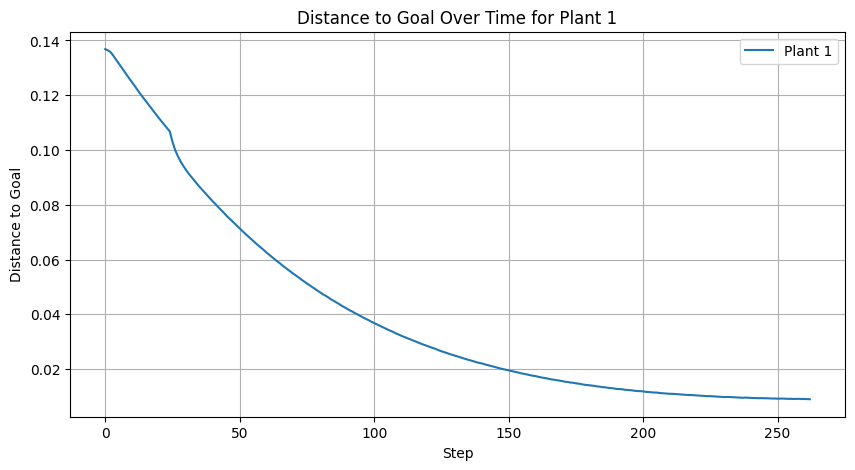

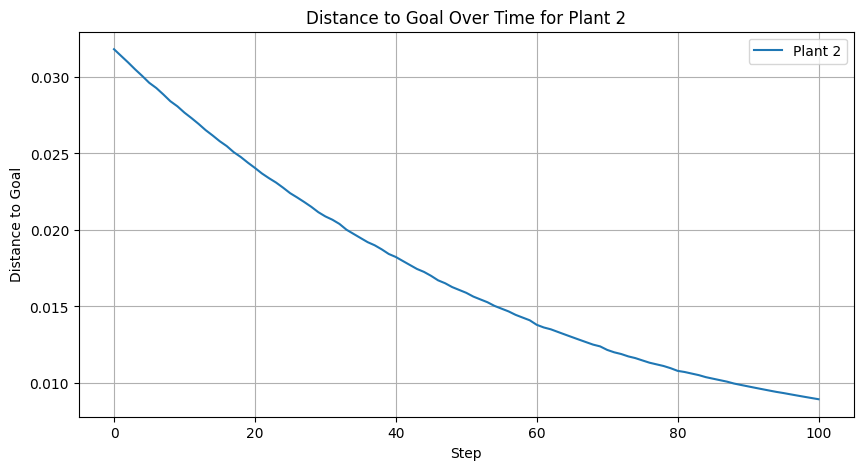

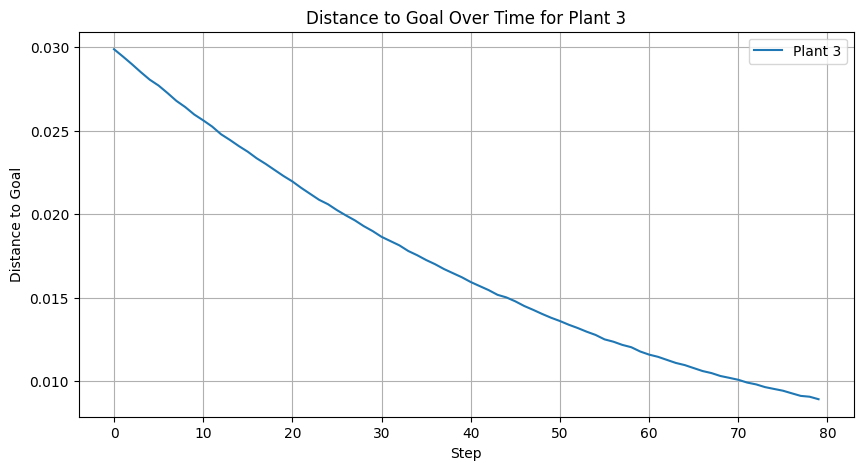

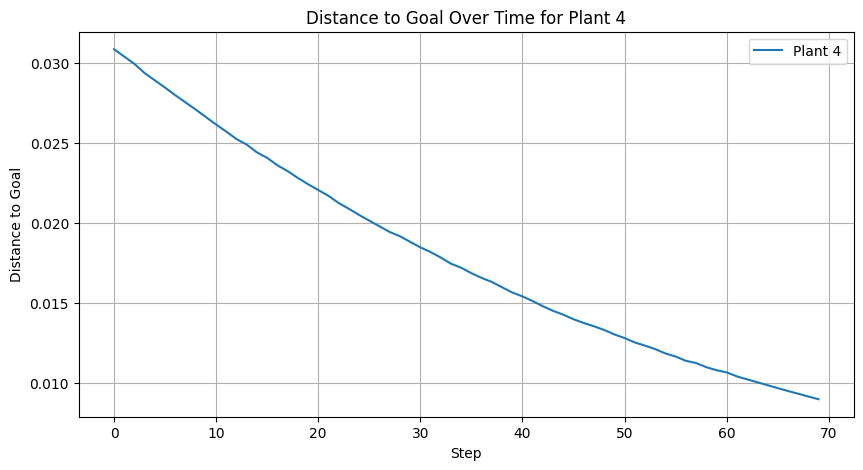

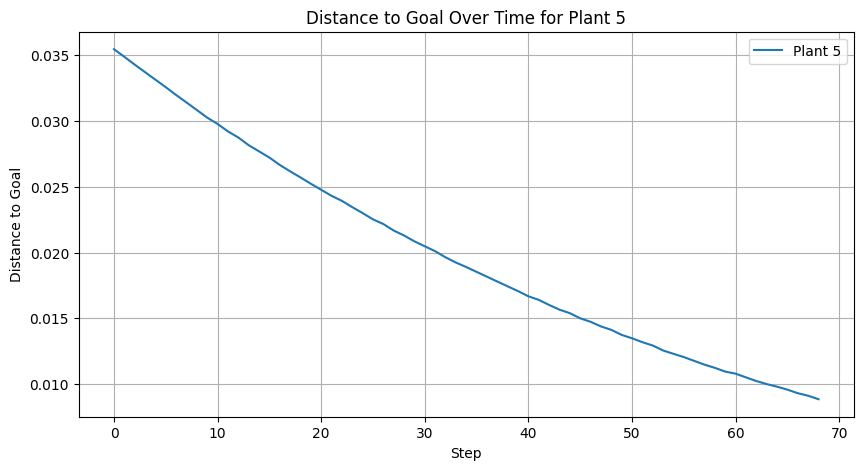

In [13]:
# Directory for saving plots
plots_directory = 'plots_dataframes'

# Data structure to hold the data for DataFrame
plant_data = []

# Resetting the environment
obs, info = env.reset()

x_adjustment = 0.014
y_adjustment = 0

# Add a counter for the goal positions
for index, goal_pos in enumerate(goal_positions, start=1):  # Start=1 to begin counting from 1

    # Initialize a list to store distances for plotting
    distances = []

    # Set the goal position for the robot
    goal_pos_x = 0.10775 + goal_pos[0] + x_adjustment
    goal_pos_y = 0.088 + goal_pos[1] + y_adjustment
    goal_pos_z = 0.1695
    goal_pos = np.array([goal_pos_x, goal_pos_y, goal_pos_z])
    env.goal_position = goal_pos
    
    # Modify the print statement to include the goal position number
    print(f'\nPlant {index}')  # Use the counter here
    print(f'Goal position is: {goal_pos_x, goal_pos_y, goal_pos_z}')

    start_time = time.time()
       
    # Run the control algorithm until the robot reaches the goal position
    for i in range(100000):
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, terminated, truncated, info = env.step(action)
        
        # calculate the distance between the pipette and the goal
        distance = obs[3:] - obs[:3]  # goal position - pipette position
        error = np.linalg.norm(distance)
        
        # Store the error for plotting
        distances.append(error)
        
        # Drop the inoculum if the robot is within the required error
        if error < 0.009:
            action = np.array([0, 0, 0, 1])
            obs, rewards, terminated, truncated, info = env.step(action)
            end_time = time.time()  # Stop the timer
            elapsed_time = end_time - start_time  # Calculate the elapsed time
            print(f'Complete with an error of \n{error} in {elapsed_time:.2f} seconds and {i} iterations')
            break

        if terminated:
            print('Episode terminated')
            obs, info = env.reset()
            print('Environment reset')
            break

    # After the loop, save the plot to a file
    plt.figure(figsize=(10, 5))
    plt.plot(distances, label=f'Plant {index}')
    plt.xlabel('Step')
    plt.ylabel('Distance to Goal')
    plt.title(f'Distance to Goal Over Time for Plant {index}')
    plt.legend()
    plt.grid(True)
    plot_filename = os.path.join(plots_directory, f'plot_plant_{index}_RL.png')
    plt.savefig(plot_filename)

    # Add the data to the list for DataFrame
    plant_data.append({'plant': index, 'error': error, 'time': elapsed_time})

# Create a DataFrame from the collected data
df_plants = pd.DataFrame(plant_data)

# Save the DataFrame to a CSV file if needed
df_plants.to_csv('plots_dataframes/data_RL.csv', index=False)


### PID

In [14]:
# Resetting the environment
obs, info = env.reset()

# Directory for saving plots
plots_directory = 'plots_dataframes'

# Data structure to hold the data for DataFrame
plants_data = []

# Function to calculate Euclidean distance between two 3D points
def calculate_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

# Function to run PID control and save plot distance over steps
def run_pid_to_goal(goal_pos_x, goal_pos_y, goal_pos_z, observation, plant_number):
    # Setup for PID controllers
    pid_x = PID(Kp=16.0, Ki=0, Kd=0)
    pid_y = PID(Kp=16.0, Ki=0, Kd=0)
    pid_z = PID(Kp=16.0, Ki=0, Kd=0)
    
    pid_x.setpoint = goal_pos_x
    pid_y.setpoint = goal_pos_y
    pid_z.setpoint = goal_pos_z
    
    distances = []  # List to store distances at each step
    threshold = 0.0005

    print(f'Goal position is: {goal_pos_x, goal_pos_y, goal_pos_z}')

    start_time = time.time()

    for i in range(5000): 
        position_x, position_y, position_z = observation[:3]

        action_x = pid_x(position_x)
        action_y = pid_y(position_y)
        action_z = pid_z(position_z)
        action = [action_x, action_y, action_z]
        observation, reward, terminated, truncated, info = env.step(action)
        
        current_distance = calculate_distance((position_x, position_y, position_z), (goal_pos_x, goal_pos_y, goal_pos_z))
        distances.append(current_distance)

        if current_distance < threshold:
            print(f"Inoculating point: ({position_x}, {position_y}, {position_z})")
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f'\nInoculation successful with an error of {current_distance} meters in {i} steps or {elapsed_time:.2f} seconds\n')
            
            # Add the data to the list for DataFrame
            plants_data.append({'plant': plant_number, 'error': current_distance, 'time': elapsed_time})
            break

    # Plotting the distance to goal over steps
    plt.figure(figsize=(10, 6))
    plt.plot(distances, label='Distance to Goal')
    plt.xlabel('Step')
    plt.ylabel('Distance in meters')
    plt.title(f'Distance to Goal Over Steps for Plant {plant_number}')
    plt.legend()
    plt.grid(True)

    # Save the plot with a new filename
    plt.savefig(os.path.join(plots_directory, f'plot_plant_{plant_number}_PID.png'))
    plt.close()


# Loop through each goal position in the list
for idx, (goal_x, goal_y) in enumerate(goal_positions, start=1):
    print(f'\n\nPlant {idx}:\n')
    obs, info = env.reset()  # Reset environment for each run

    # Additional offset or adjustments
    offset_x = 0.10775
    offset_y = 0.088
    goal_pos_z = 0.1695  # Fixed value for simplicity
    
    # Calculating the adjusted goal positions
    goal_pos_x = offset_x + goal_x
    goal_pos_y = offset_y + goal_y
    
    run_pid_to_goal(goal_pos_x, goal_pos_y, goal_pos_z, obs, idx)

# Create a DataFrame from the collected data and save it
df = pd.DataFrame(plants_data)

df.to_csv(os.path.join(plots_directory, 'data_PID.csv'), index=False)




Plant 1:

Goal position is: (0.18398038516405135, 0.11367760342368045, 0.1695)
Inoculating point: (0.1835000067949295, 0.1136000007390976, 0.16949999332427979)

Inoculation successful with an error of 0.00048660615924913867 meters in 81 steps or 0.72 seconds



Plant 2:

Goal position is: (0.17087410841654777, 0.1373758915834522, 0.1695)
Inoculating point: (0.1704999953508377, 0.1371999979019165, 0.16949999332427979)

Inoculation successful with an error of 0.0004133995321522815 meters in 82 steps or 0.70 seconds



Plant 3:

Goal position is: (0.17044614835948646, 0.16439087018544934, 0.1695)
Inoculating point: (0.17010000348091125, 0.16410000622272491, 0.16949999332427979)

Inoculation successful with an error of 0.0004521262233272558 meters in 83 steps or 0.71 seconds



Plant 4:

Goal position is: (0.1690552781740371, 0.18990798858773178, 0.1695)
Inoculating point: (0.16869999468326569, 0.18960000574588776, 0.16949999332427979)

Inoculation successful with an error of 0.000470191

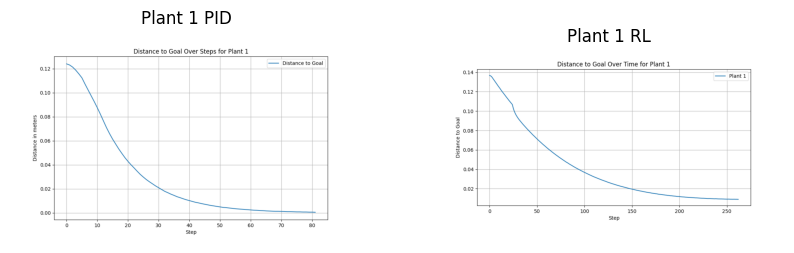

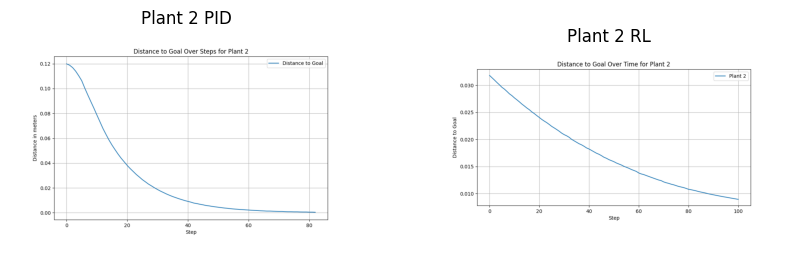

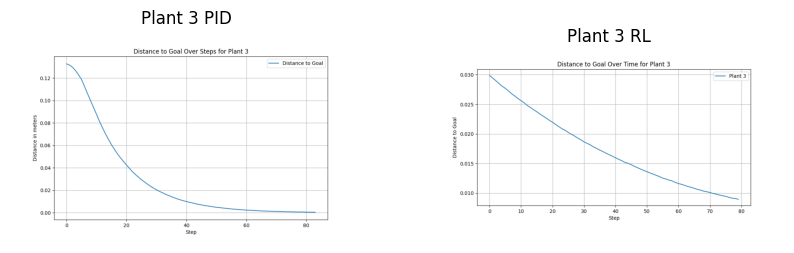

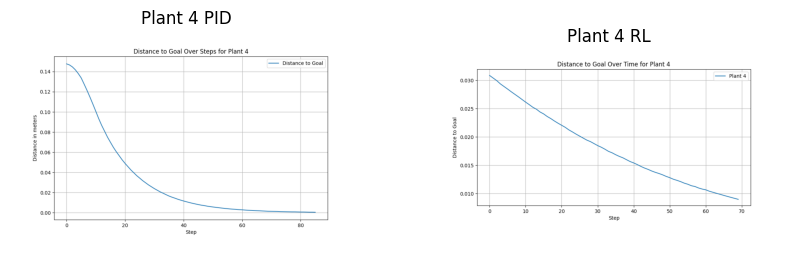

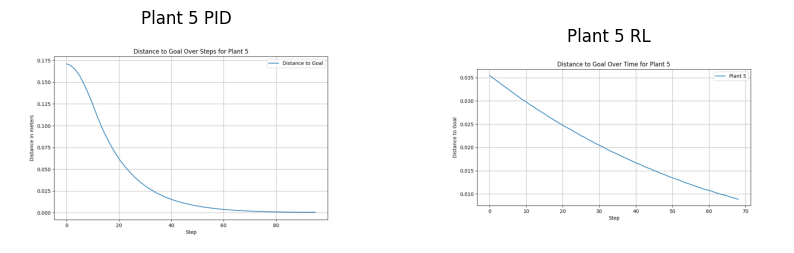

In [15]:
# Define the base path for the images
base_path = 'plots_dataframes/'

# Define the plants
plants = range(1, 6)  # Plant 1 to Plant 5

# Display each PID and RL image side by side
for plant in plants:
    # Load images
    img_pid = mpimg.imread(f'{base_path}plot_plant_{plant}_PID.png')
    img_rl = mpimg.imread(f'{base_path}plot_plant_{plant}_RL.png')
    
    # Plot images side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img_pid)
    axs[0].set_title(f'Plant {plant} PID')
    axs[0].axis('off')  # Hide axes
    
    axs[1].imshow(img_rl)
    axs[1].set_title(f'Plant {plant} RL')
    axs[1].axis('off')  # Hide axes
    
    plt.show()


In [18]:
# Load the dataframes
df_pid = pd.read_csv('plots_dataframes/data_PID.csv')
df_pid

,plant,error,time
0,1,0.000487,0.723148
1,2,0.000413,0.701229
2,3,0.000452,0.713755
3,4,0.000470,0.820398
4,5,0.000490,1.078483


In [19]:
df_rl = pd.read_csv('plots_dataframes/data_RL.csv')
df_rl

,plant,error,time
0,1,0.008995,2.504833
1,2,0.008936,0.872136
2,3,0.008931,0.739810
3,4,0.008988,0.659379
4,5,0.008850,0.845987


In [21]:
# Initialize lists to store results
lowest_time_plants = []
lowest_error_plants = []

# Compare data for each plant
for plant in plants:
    # Get data for the current plant from both dataframes
    pid_row = df_pid[df_pid['plant'] == plant]
    rl_row = df_rl[df_rl['plant'] == plant]
    
    # Determine lowest time
    lowest_time = 'PID' if pid_row['time'].values[0] < rl_row['time'].values[0] else 'RL'
    lowest_time_plants.append((plant, lowest_time))
    
    # Determine lowest error
    lowest_error = 'PID' if pid_row['error'].values[0] < rl_row['error'].values[0] else 'RL'
    lowest_error_plants.append((plant, lowest_error))

# Display the results
print("\nLowest Time for Each Plant:\n")
for plant, method in lowest_time_plants:
    print(f"Plant {plant}: {method}")

print("\nLowest Error for Each Plant:\n")
for plant, method in lowest_error_plants:
    print(f"Plant {plant}: {method}")



Lowest Time for Each Plant:

Plant 1: PID
Plant 2: PID
Plant 3: PID
Plant 4: RL
Plant 5: RL

Lowest Error for Each Plant:

Plant 1: PID
Plant 2: PID
Plant 3: PID
Plant 4: PID
Plant 5: PID
